In [122]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

# Target and feature name

In [3]:
y_name = ['ccn_001',
 'ccn_003',
 'ccn_006',
 'CHI',
 'CHI_CCN',
 'D_ALPHA',
 'D_GAMMA',
 'D_ALPHA_CCN',
 'D_GAMMA_CCN',
 'PM25']

In [12]:
x_name = ['TOT_NUM_CONC',
 'TOT_MASS_CONC',
 'pmc_SO4',
 'pmc_NO3',
 'pmc_Cl',
 'pmc_NH4',
 'pmc_ARO1',
 'pmc_ARO2',
 'pmc_ALK1',
 'pmc_OLE1',
 'pmc_API1',
 'pmc_API2',
 'pmc_LIM1',
 'pmc_LIM2',
 'pmc_OC',
 'pmc_BC',
 'pmc_H2O',
 'TEMPERATURE',
 'REL_HUMID',
 'ALT',
 'Z',
#  'XLAT',
#  'XLONG',
 'h2so4',
 'hno3',
 'hcl',
 'nh3',
 'no',
 'no2',
 'no3',
 'n2o5',
 'hono',
 'hno4',
 'o3',
 'o1d',
 'O3P',
 'oh',
 'ho2',
 'h2o2',
 'co',
 'so2',
 'ch4',
 'c2h6',
 'ch3o2',
 'ethp',
 'hcho',
 'ch3oh',
 'ANOL',
 'ch3ooh',
 'ETHOOH',
 'ald2',
 'hcooh',
 'RCOOH',
 'c2o3',
 'pan',
 'aro1',
 'aro2',
 'alk1',
 'ole1',
 'api1',
 'api2',
 'lim1',
 'lim2',
 'par',
 'AONE',
 'mgly',
 'eth',
 'OLET',
 'OLEI',
 'tol',
 'xyl',
 'cres',
 'to2',
 'cro',
 'open',
 'onit',
 'rooh',
 'ro2',
 'ano2',
 'nap',
 'xo2',
 'xpar',
 'isop',
 'isoprd',
 'isopp',
 'isopn',
 'isopo2',
 'api',
 'lim',
 'dms',
 'msa',
 'dmso',
 'dmso2',
 'ch3so2h',
 'ch3sch2oo',
 'ch3so2',
 'ch3so3',
 'ch3so2oo',
 'ch3so2ch2oo',
 'SULFHOX',
 'P',
 'PB',
#  'cos(Time)'
         ]

# Read prediction, feature, and truth (flattened data)

In [61]:
ds = xr.open_dataset("/home/chuchun2/hackathon_data/training.nc")

In [7]:
# y = np.zeros((10, 12*39*159*169))*np.nan  # truth
# for iy in range(len(y_name)):
#     y[iy, :] = ds[y_name[iy]][0:12].values.flatten()
    
# y_hat = np.zeros((10, 12*39*159*169))*np.nan  # prediction
# for iy in range(len(y_name)):
#     y_hat[iy, :] = ds[y_name[iy]][-12::].values.flatten()
    
# x = np.zeros((100, 12*39*159*169))*np.nan  # feature
# for ix in range(len(x_name)):
#     x[ix, :] = ds[x_name[ix]][0:12].values.flatten()

In [54]:
y = np.zeros((12*39*159*169, 10))*np.nan  # truth
for iy in range(len(y_name)):
    y[:, iy] = ds[y_name[iy]][0:12].values.flatten()
    
y_hat = np.zeros((12*39*159*169, 10))*np.nan  # prediction
for iy in range(len(y_name)):
    y_hat[:, iy] = ds[y_name[iy]][-12::].values.flatten()
    
x = np.zeros((12*39*159*169, 100))*np.nan  # feature
for ix in range(len(x_name)):
    x[:, ix] = ds[x_name[ix]][0:12].values.flatten()

# Reshape flattened data

In [69]:
y_reshape = y.transpose().reshape(10, 12, 39, 159, 169)  # truth
y_hat_reshape = y_hat.transpose().reshape(10, 12, 39, 159, 169)  # prediction
x_reshape = x.transpose().reshape(100, 12, 39, 159, 169)  # feature

# Function for r-values between errors and features

In [76]:
def plot_corr_error_vs_feature(prediction, feature, truth):
    '''
    The size of input data should be:
        prediction: 12575628 x 10
        feature: 12575628 x 100
        truth: 12575628 x 10
    
    The size of this plot would be 10 (error) x 100 (feature)
    Each grid represents the correlation between error and feature for all the points (all lat, lon, lev, and time)
    '''
    error = np.absolute(prediction - truth)
    r = np.zeros((error.shape[1], feature.shape[1])) * np.nan
    for i_error in range(error.shape[1]):
        for i_feature in range(feature.shape[1]):
            r[i_error, i_feature] = np.absolute(np.corrcoef(error[:, i_error], feature[:, i_feature])[0, 1])
    
    fig = plt.figure(figsize=(25, 5))
    sns.heatmap(r, xticklabels=x_name, yticklabels=y_name, vmin=0, vmax=1, cmap="viridis", linewidths=.5)
    # plt.title('')
    plt.tight_layout()
    # fig.savefig('corr_error_vs_feature.png', dpi=150)
    
    return r

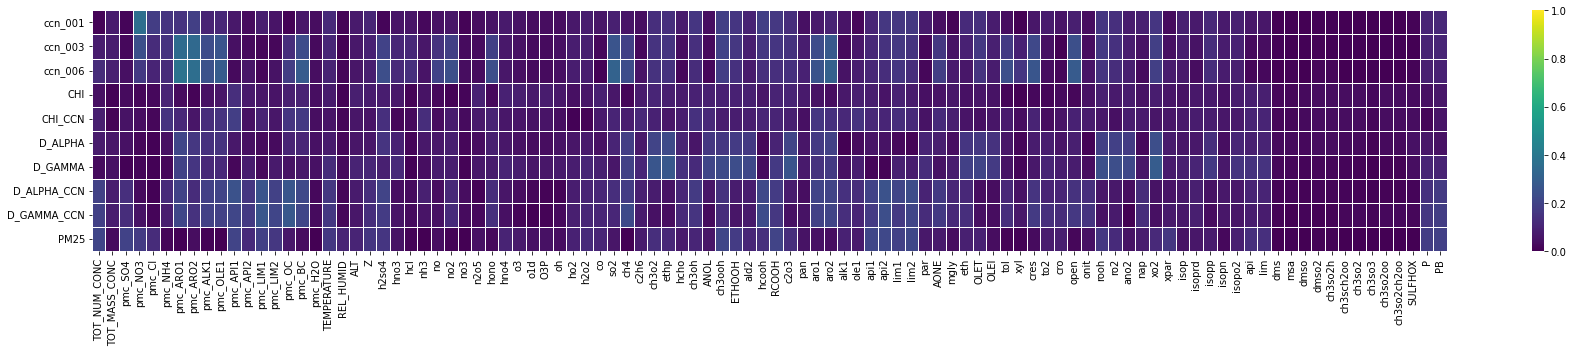

In [77]:
r = plot_corr_error_vs_feature(y_hat, x, y)

# Function for error on z-t space

In [120]:
def plot_error_vs_z_t(prediction, feature, truth):
    '''
    The size of input data should be:
        prediction: 12575628 x 10
        feature: 12575628 x 100
        truth: 12575628 x 10
    Then we will reshape the flattened data to original shape.
    This function will return 10 plots for all 10 targets.
    '''
    truth_reshape = truth.transpose().reshape(10, 12, 39, 159, 169)  # truth
    prediction_reshape = prediction.transpose().reshape(10, 12, 39, 159, 169)  # prediction
    feature_reshape = feature.transpose().reshape(100, 12, 39, 159, 169)  # feature
    
    error = np.absolute(prediction_reshape - truth_reshape)
    e_2d = np.mean(np.reshape(error, (10, 12, 39, 159*169)), axis=3)
    
#     e_2d = np.zeros((10, 12, 39)) * np.nan
#     for itarget in range(error.shape[0]):
#         for it in range(error.shape[1]):
#             for iz in range(error.shape[2]):
#                 e_2d[itarget, it, iz] = error[itarget, it, iz, :, :].mean()

    for itarget in range(10):
        fig = plt.figure(figsize=(25, 5))
        s= sns.heatmap(e_2d[itarget], cmap="viridis", linewidths=.5)
        s.set(xlabel='bottom_top', ylabel='Time')
        plt.title('area mean absolute error for '+y_name[0])
        plt.tight_layout()
#         fig.savefig('error_vs_z_t_target'+str(itarget)+'.png', dpi=150)     
    
    return e_2d
    

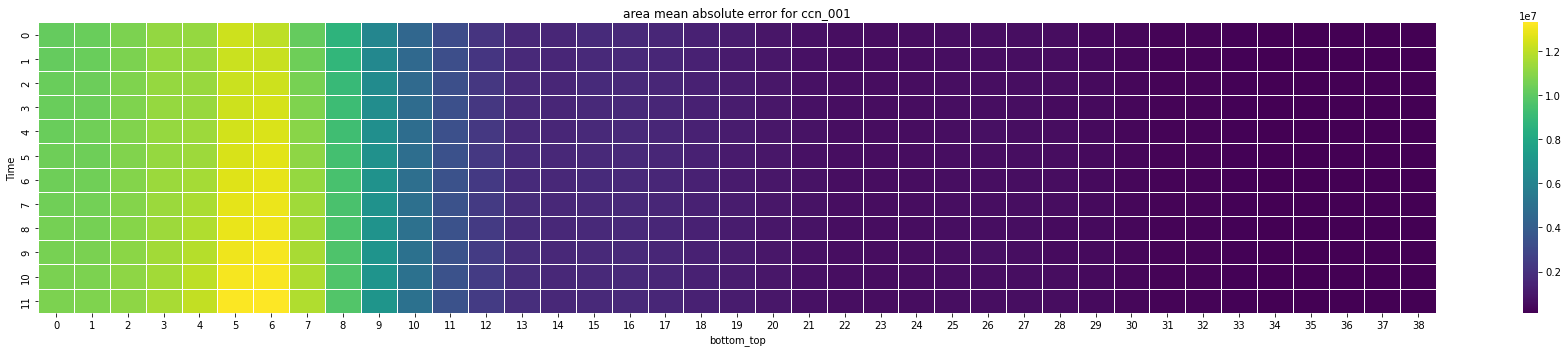

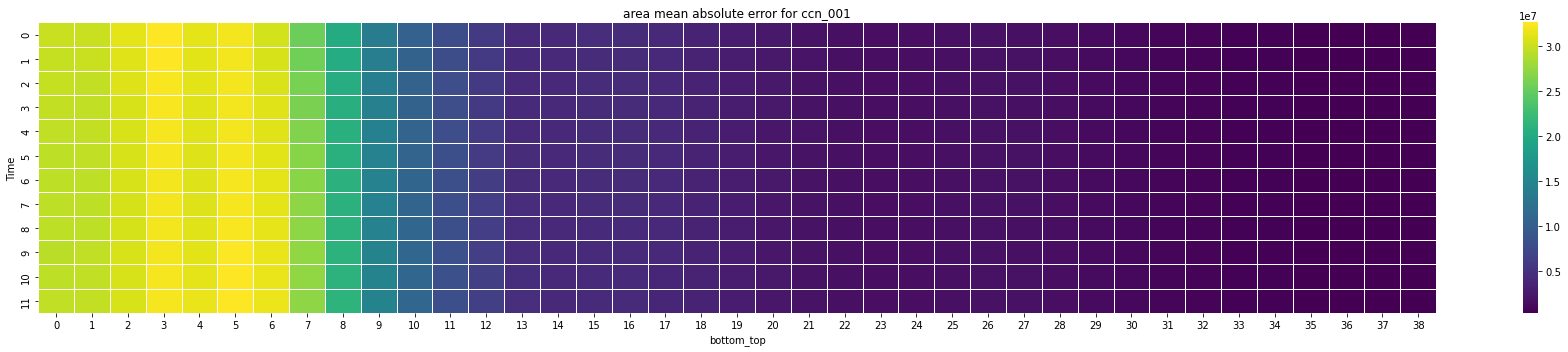

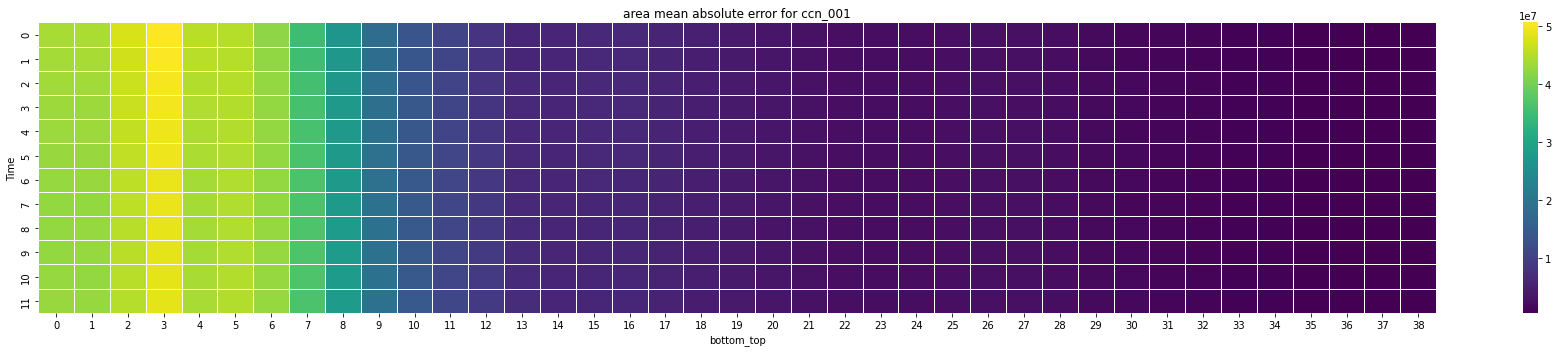

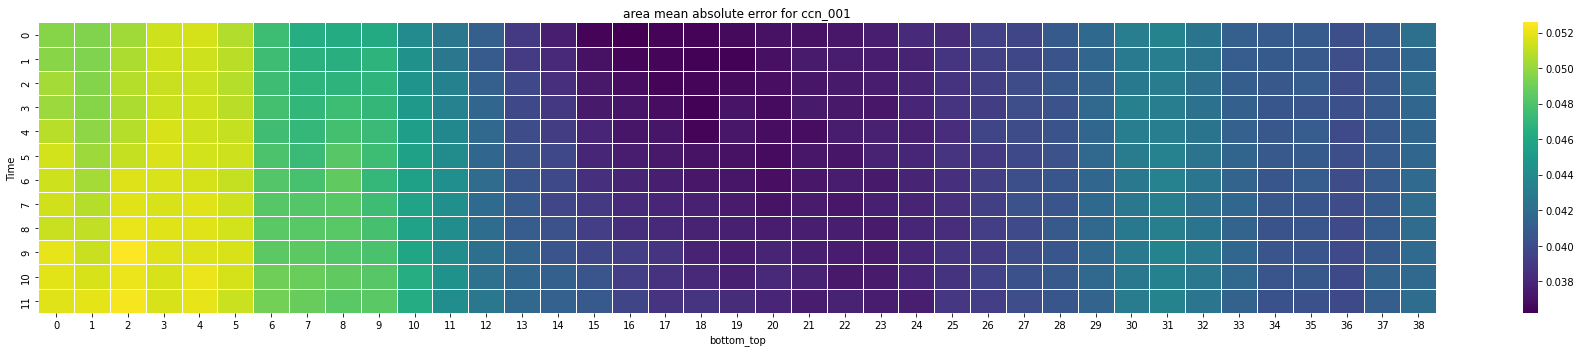

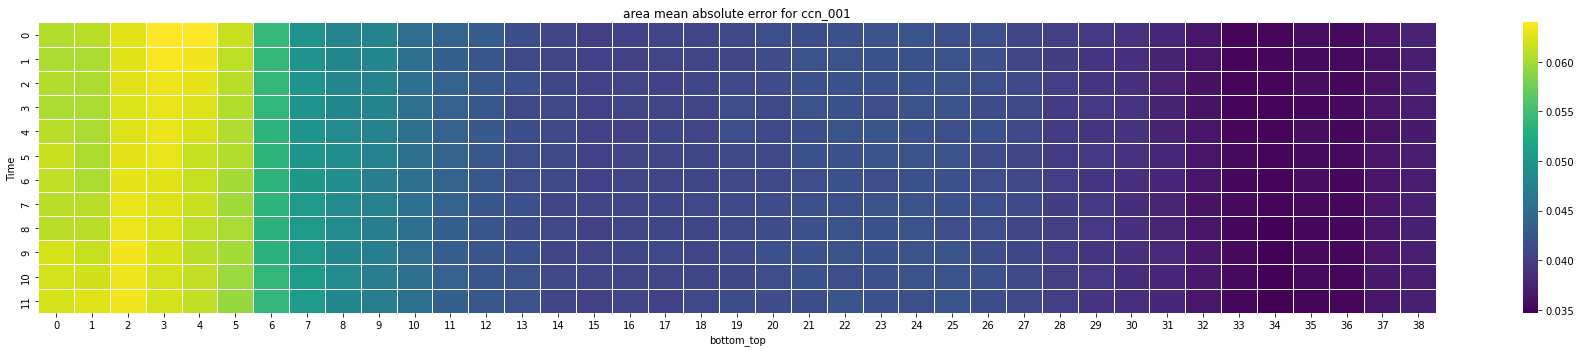

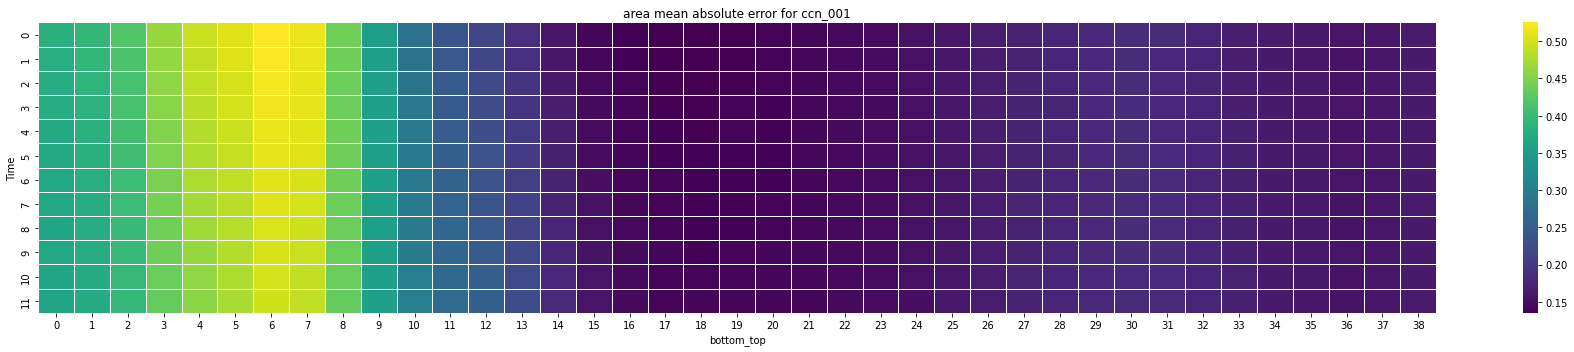

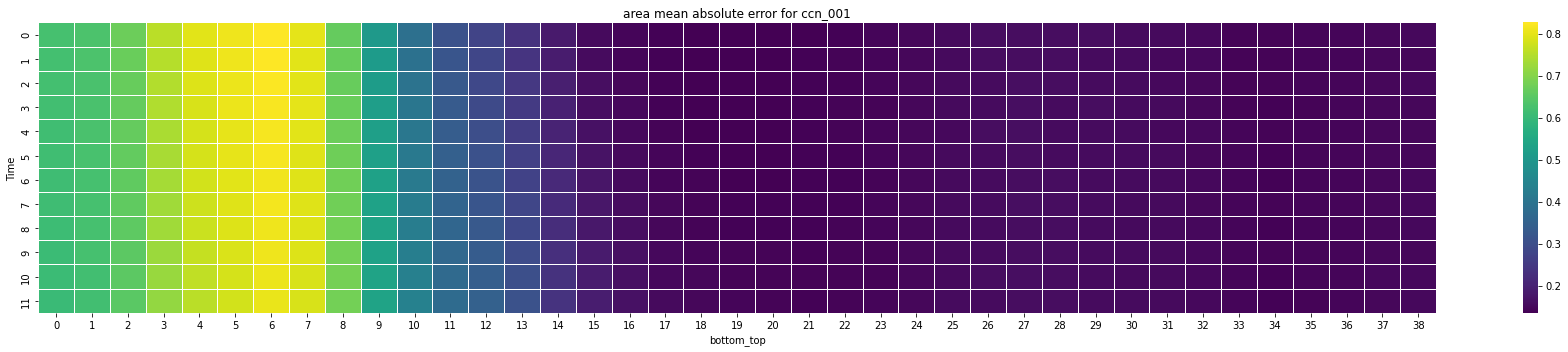

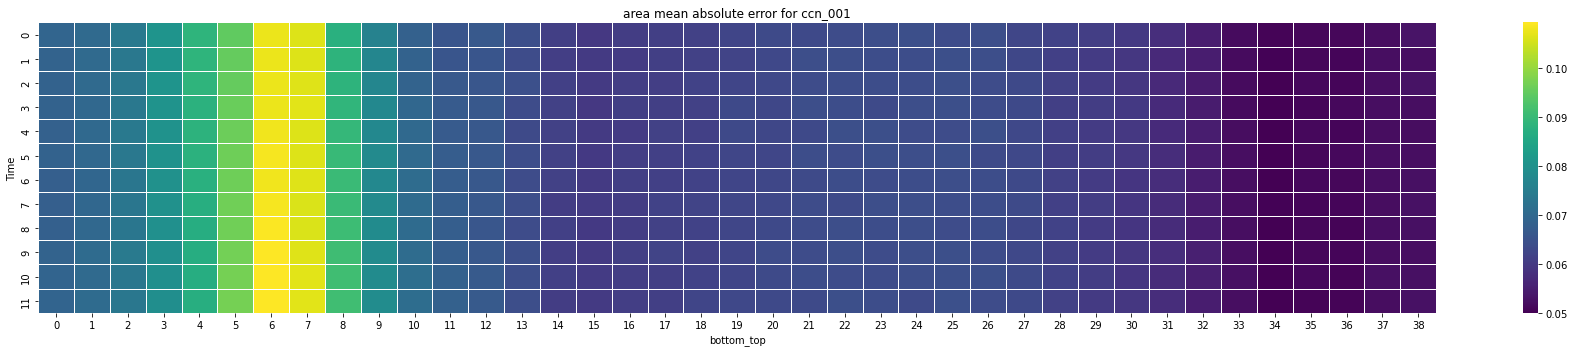

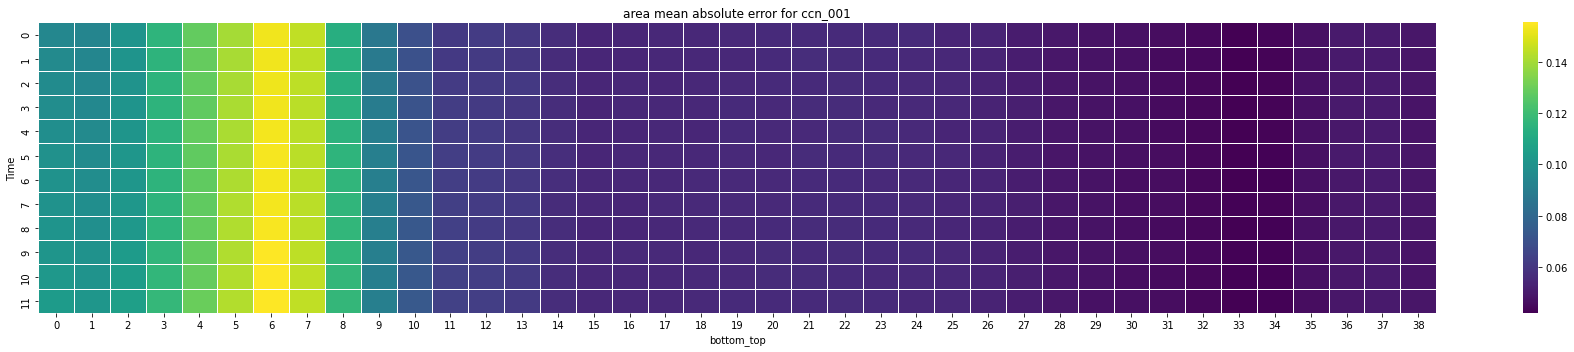

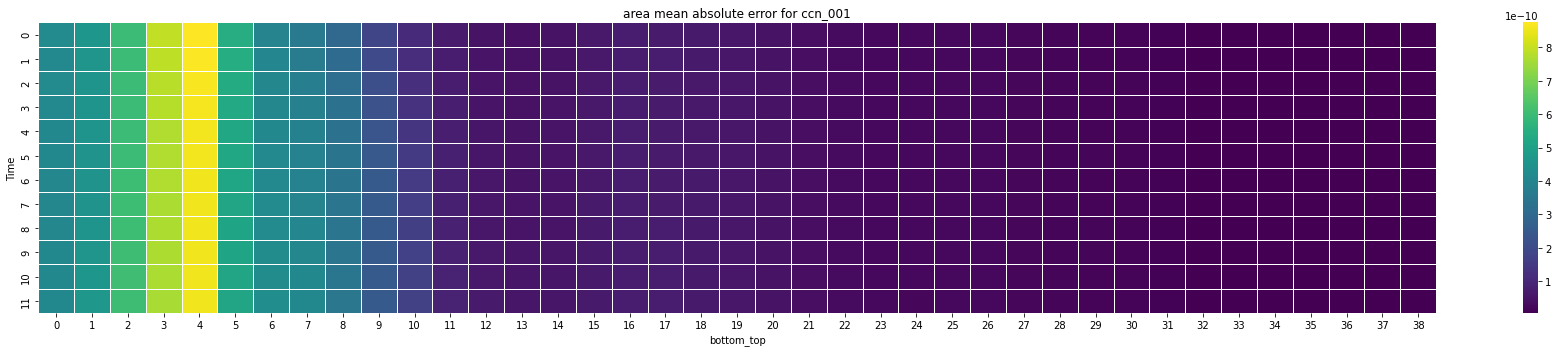

In [121]:
e_2d = plot_error_vs_z_t(y_hat, x, y)

# Function for prediction vs truth

In [133]:
def plot_y_hat_vs_y(prediction, feature, truth):
    '''
    The size of input data should be:
        prediction: 12575628 x 10
        feature: 12575628 x 100
        truth: 12575628 x 10
    '''
    
    f,axes = plt.subplots(2,5,figsize=(16,5), constrained_layout=True)

    for i in range(10):
        ax = axes.flat[i]

        _min = truth[:, i].min()
        _max = truth[:, i].max()
        im = ax.hexbin(truth[:, i], prediction[:, i], gridsize=64, extent=(_min,_max,_min,_max), mincnt=1) #, norm=colors.LogNorm(1,1e4))
        ax.set_aspect(1.0)
        ax.axline([0, 0], slope=1, color='k', alpha=0.4)
        ax.set_title(y_name[i])
        ax.set_xlim(_min,_max)
        ax.set_ylim(_min,_max)

        if i==5:
            ax.set_xlabel('ground truth')
            ax.set_ylabel('MLP prediction')

        if i == 9:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            f.colorbar(im, cax=cax)  
    return

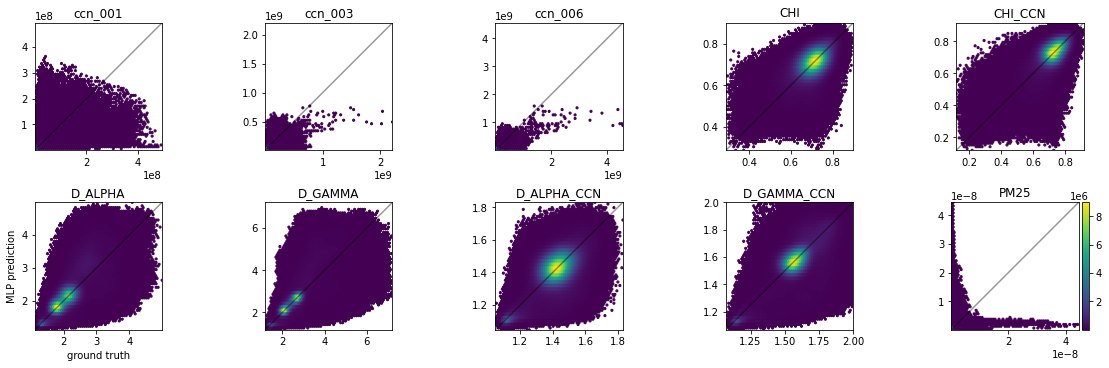

In [138]:
plot_y_hat_vs_y(y_hat, x, y)